# demonstrating the 'f-principle'

Here we try and demonstrate the f-principle, the tendency for ANNs for first fit low frequency data then high frequency.

There are quite a few papers on this which you can find by looking at this paper and papers it references and papers that
reference this: https://arxiv.org/abs/1901.06523

We also look at the multi-scale artificial neural network (M-scale ANN) from: https://arxiv.org/abs/1910.11710

We show that the M-scale ANN and drastically improve the performance of these ANNs for these regression tasks.

# imports

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
mpl.rcParams.update({"font.size": 16})

here we use one of my libraries, pugna, to make building and training the networks easier.

In [4]:
import pugna.layers
import pugna.activations

In [5]:
import tensorflow as tf

## generate fake training data

here we generate some fake data, which is just a 1D time series composed of two frequencies.

wave 1 with a frequency of 1Hz and wave 2 with a frequency of 4 Hz.

In [6]:
def gen_data(npoints=201):
    """
    example from https://github.com/xuzhiqin1990/F-Principle/blob/master/main_1d_20190924.py
    """
    x = np.linspace(-2, 2, npoints)[:,np.newaxis]
    
    f=1
    om = 2*np.pi*f
    y1 = np.sin(om*x)
    
    f=4
    om = 2*np.pi*f
    y2 = np.sin(om*x)
    
    y = y1+y2
    return x, y, y1, y2

In [7]:
x, y, y1, y2 = gen_data(npoints=101)

In [8]:
x.shape

(101, 1)

In [9]:
def compute_fft(x, y):
    """
    function to compute the fourier transform and sample frequencies.
    only keeping the positive side of the fft and normalising.
    """
    N = len(x)
    dt = x[1] - x[0]
    
    yf = 2.0/N * np.fft.fft(y)[:N//2]
    xf = np.fft.fftfreq(N, dt)[:N//2]

    return xf, yf

In [10]:
xf, yf = compute_fft(x[:,0], y[:,0])
_, y1f = compute_fft(x[:,0], y1[:,0])
_, y2f = compute_fft(x[:,0], y2[:,0])

Text(0.5, 1.0, 'fourier domain showing the peaks for 1 and 4 Hz')

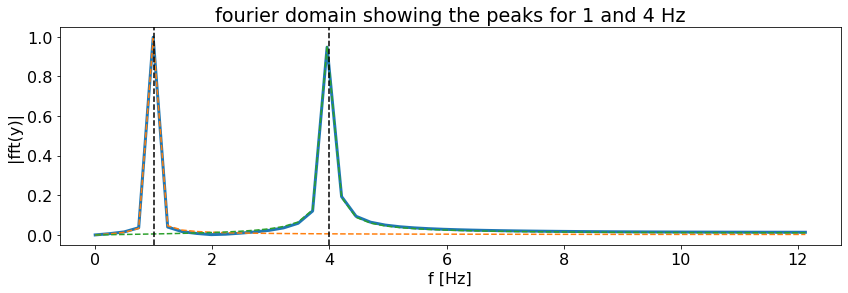

In [12]:
plt.figure(figsize=(14, 4))
plt.plot(xf, np.abs(yf), lw=3)
plt.plot(xf, np.abs(y1f), ls='--')
plt.plot(xf, np.abs(y2f), ls='--')
plt.axvline(1, c='k', ls='--')
plt.axvline(4, c='k', ls='--')
plt.xlabel("f [Hz]")
plt.ylabel("|fft(y)|")
plt.title("fourier domain showing the peaks for 1 and 4 Hz")

Text(0.5, 0, 't [s]')

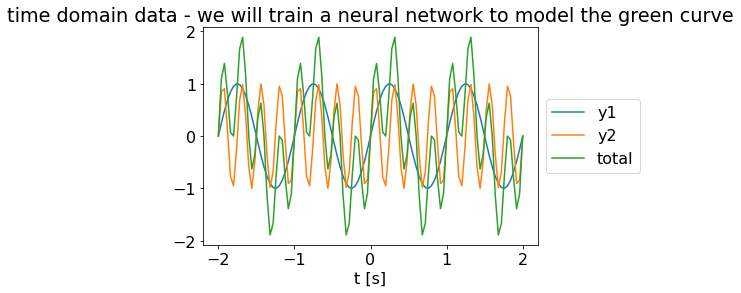

In [14]:
plt.plot(x, y1, label='y1')
plt.plot(x, y2, label='y2')
plt.plot(x, y, label='total')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("time domain data - we will train a neural network to model the green curve")
plt.xlabel("t [s]")

this is a helper function to plot the training history

In [15]:
def plot_history(history, labels=None):
    plt.figure()
    for i, h in enumerate(history):
        loss = h.history["loss"]
        if labels:
            plt.plot(range(len(loss)), loss, label=labels[i])
        else:
            plt.plot(range(len(loss)), loss)
    plt.yscale("log")
    plt.title('train')    
    if labels:
        plt.legend(bbox_to_anchor=(1.05, 1))
    
    if "val_loss"  in history[0].history.keys():
        plt.figure()
        for h in history:
            loss = h.history["val_loss"]
            plt.plot(range(len(loss)), loss, ls='--')
        plt.yscale("log")
        plt.title('validation')

these lines allows us to use our sReLU and s2ReLU activations functions from the M-scale paper

In [16]:
# https://datascience.stackexchange.com/questions/58884/how-to-create-custom-activation-functions-in-keras-tensorflow
from tensorflow.keras.utils import get_custom_objects
get_custom_objects().update({'srelu': tf.keras.layers.Activation(pugna.activations.sReLU)})
get_custom_objects().update({'s2relu': tf.keras.layers.Activation(pugna.activations.s2relu)})

main function to build and fit the ANNs

In [17]:
def build_and_fit_model(
    x,
    y,
    verbose=False,
    batch_size=None,
    nscales=1,
    epochs=1000,
    units=300,
    lr=0.001,
    activation='srelu',
    validation_data=None,
    scale_name='linear',
    use_mscale=False
):
    if batch_size is None:
        batch_size = x.shape[0]

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(1,)))
    if use_mscale:
        model.add(pugna.layers.Mscale(units, nscales, scale_name=scale_name))
    else:
        model.add(tf.keras.layers.Dense(units))
    if activation == 'srelu':
        model.add(tf.keras.layers.Activation(pugna.activations.sReLU))
    elif activation == 's2relu':
        model.add(tf.keras.layers.Activation(pugna.activations.s2relu))
    elif activation == 'relu':
        model.add(tf.keras.layers.Activation(tf.keras.activations.relu))
    elif activation == 'tanh':
        model.add(tf.keras.layers.Activation(tf.keras.activations.tanh))

    model.add(tf.keras.layers.Dense(units, activation=activation))
    model.add(tf.keras.layers.Dense(units, activation=activation))
    model.add(tf.keras.layers.Dense(units, activation=activation))
    model.add(tf.keras.layers.Dense(units, activation=activation))
    model.add(tf.keras.layers.Dense(1, activation="linear"))

    # optimizer = tf.keras.optimizers.Adam(lr)
    optimizer = tf.keras.optimizers.Adam(lr, amsgrad=True)
    #optimizer = tf.keras.optimizers.Adam(lr, amsgrad=True, clipnorm=0.5)
    #optimizer = tf.keras.optimizers.Adam(lr, amsgrad=True, clipvalue=5.0)
    #optimizer = tf.keras.optimizers.Nadam(lr)
    # optimizer = tf.keras.optimizers.SGD(lr)
    model.compile(loss="mse", optimizer=optimizer)

    history = model.fit(x, y, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=validation_data)

    return history, model

# standard dense layer

lets train the standard feed-forward fully connected ANN

we will repeat the training 10 times so that we can see how the
performance of the training changes and how stable it is.

In general, it is a good idea to repeat the training multiple times is possible.
Sometimes you can get lucky (or unlucky) with the training

In [21]:
def lowest_loss(historys, models):
    losses = [history.history['loss'][-1] for history in historys]
    idx = np.argmin(losses)
    print(f"idx: {idx} had the lowest loss")
    return historys[idx], models[idx]

In [22]:
%%time
ntries = 10
history1s = []
model1s = []

print("working")
for i in range(ntries):
    print(f"{i}", end=",")
    history, model = build_and_fit_model(x, y, activation='relu', epochs=100)

    history1s.append(history)
    model1s.append(model)
print("done")

working
0,1,2,3,4,5,6,7,8,9,done
CPU times: user 12.2 s, sys: 1.23 s, total: 13.4 s
Wall time: 5.79 s


In [23]:
history1, model1 = lowest_loss(history1s, model1s)

idx: 4 had the lowest loss


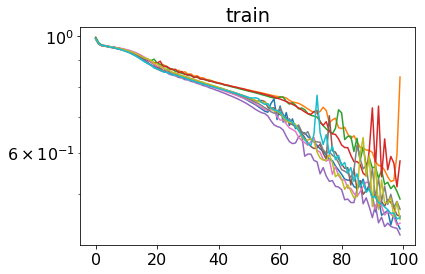

In [24]:
plot_history(history1s)

In [25]:
yhat1 = model1.predict(x)

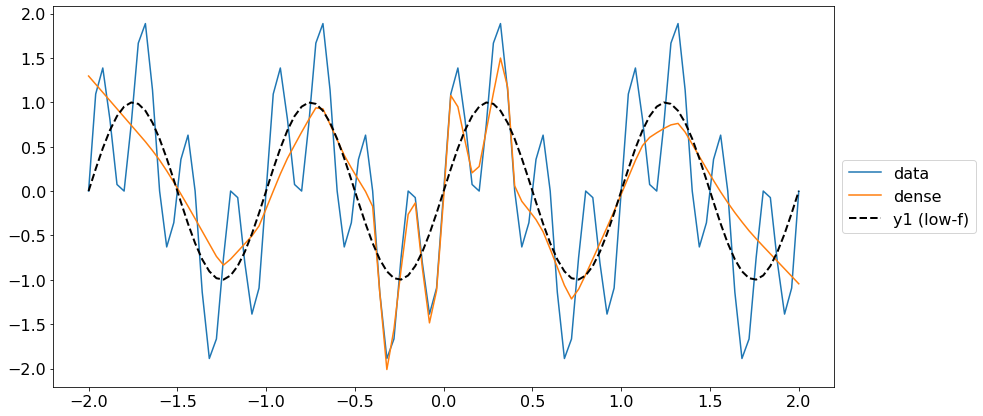

In [26]:
plt.figure(figsize=(14, 7))
plt.plot(x, y, label='data')
plt.plot(x, yhat1, label='dense')
plt.plot(x, y1, label='y1 (low-f)', lw=2, c='k', ls='--')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [27]:
_, yhat1f = compute_fft(x[:,0], yhat1[:,0])

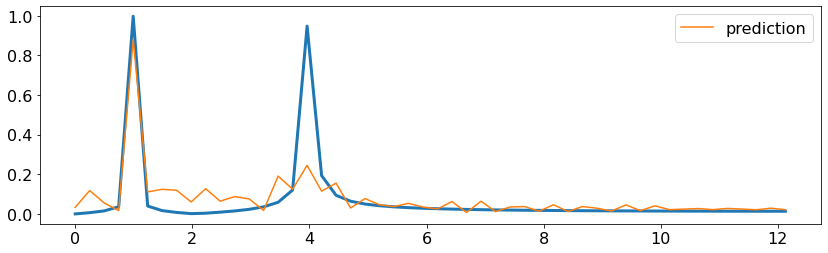

In [28]:
plt.figure(figsize=(14, 4))
plt.plot(xf, np.abs(yf), lw=3)
# plt.plot(xf, np.abs(y1f), ls='--')
# plt.plot(xf, np.abs(y2f), ls='--')

plt.plot(xf, np.abs(yhat1f), label='prediction')

# plt.axvline(1, c='k', ls='--')
# plt.axvline(4, c='k', ls='--')

plt.legend()

This is the fourier transform of our ANN prediction.

We see that the ANN prediction (in orange) peaks up the low frequency peak but doesn't pick up the higher frequency peak.

This is the f-principle in action.

# M-scale network

Now let's see if we can do better! Let's us an M-scale network!

In [29]:
%%time
ntries = 10
history2s = []
model2s = []

print("working")
for i in range(ntries):
    print(f"{i}", end=",")
    history, model = build_and_fit_model(x, y, activation='s2relu', epochs=100, nscales=10, units=300, scale_name='linear', use_mscale=True)

    history2s.append(history)
    model2s.append(model)
print("done")

working
0,1,2,3,4,5,6,7,8,9,done
CPU times: user 16.2 s, sys: 3.02 s, total: 19.2 s
Wall time: 8.43 s


In [30]:
history2, model2 = lowest_loss(history2s, model2s)

idx: 4 had the lowest loss


In [31]:
model2.layers[0].K.numpy()

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  4.,
        4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
        4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
        4.,  4.,  4.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  6.,  6.,  6.,  6.,  6.,  6.,
        6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
        6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  7

In [32]:
np.unique(model2.layers[0].K.numpy())

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.], dtype=float32)

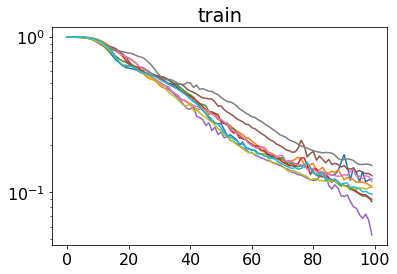

In [33]:
plot_history(history2s)

In [34]:
yhat2 = model2.predict(x)

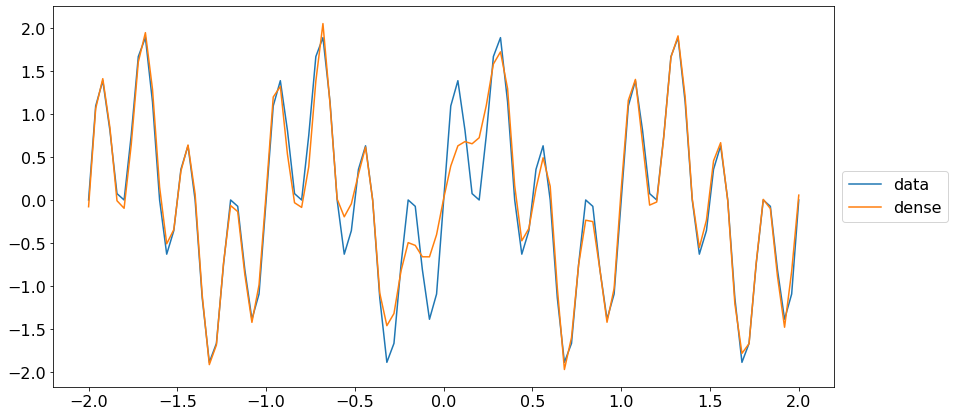

In [35]:
plt.figure(figsize=(14, 7))
plt.plot(x, y, label='data')
plt.plot(x, yhat2, label='dense')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [36]:
_, yhat2f = compute_fft(x[:,0], yhat2[:,0])

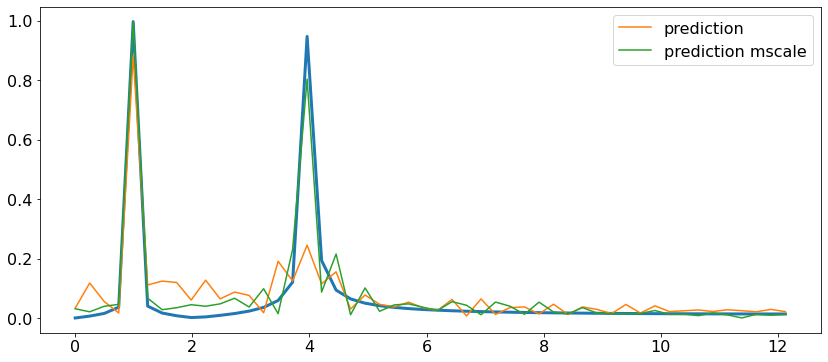

In [40]:
plt.figure(figsize=(14, 6))
plt.plot(xf, np.abs(yf), lw=3)
# plt.plot(xf, np.abs(y1f), ls='--')
# plt.plot(xf, np.abs(y2f), ls='--')

plt.plot(xf, np.abs(yhat1f), label='prediction')
plt.plot(xf, np.abs(yhat2f), label='prediction mscale')

# plt.axvline(1, c='k', ls='--')
# plt.axvline(4, c='k', ls='--')

plt.legend()

now in green is the m-scale prediction. We see that it has picked up the second peak.

The training loss plot below shows about an order of magnitude improvement for the M-scale network
over the dense network in the same time.

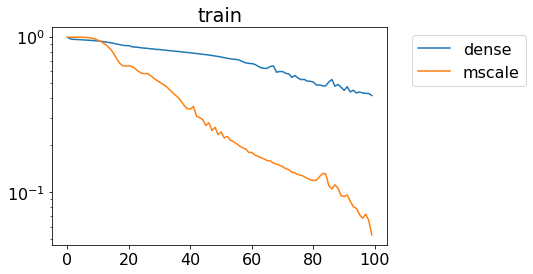

In [41]:
plot_history([history1, history2], labels=['dense', 'mscale'])

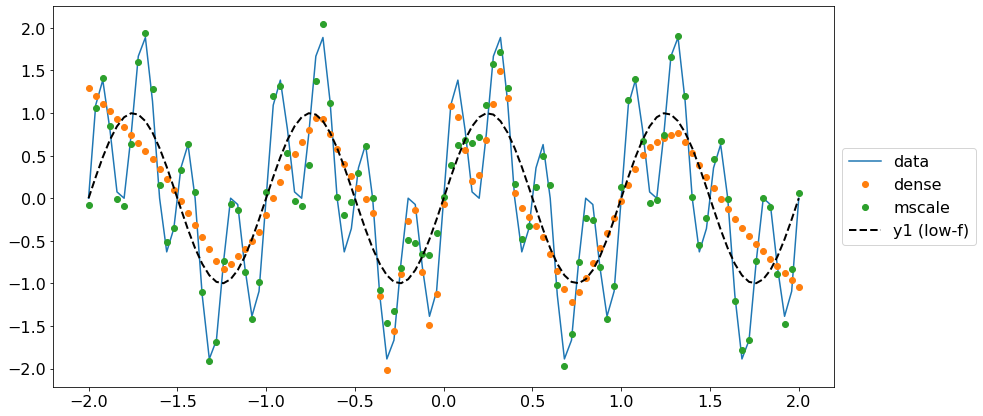

In [42]:
plt.figure(figsize=(14, 7))
plt.plot(x, y, '-', label='data')
plt.plot(x, yhat1, 'o', label='dense')
plt.plot(x, yhat2, 'o', label='mscale')
plt.plot(x, y1, label='y1 (low-f)', lw=2, c='k', ls='--')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [43]:
yres1 = tf.keras.losses.mse(y, yhat1)
yres2 = tf.keras.losses.mse(y, yhat2)

Text(0.5, 1.0, 'MSE residuals')

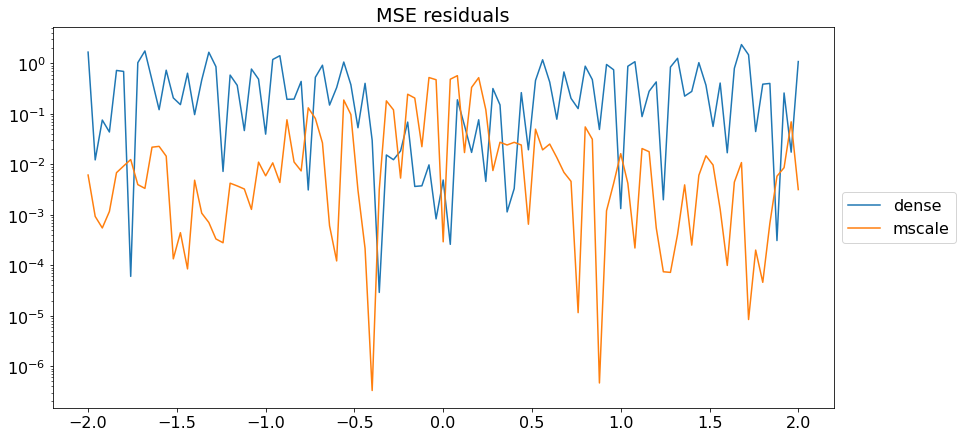

In [44]:
plt.figure(figsize=(14, 7))
plt.plot(x, yres1, '-', label='dense')
plt.plot(x, yres2, '-', label='mscale')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.yscale('log')
plt.title("MSE residuals")

# run for longer

let's re-run these tests for longer to see what happens

Can we just training for longer to obtain a better model?

# standard dense layer

In [45]:
%%time
ntries = 10
history1s = []
model1s = []

print("working")
for i in range(ntries):
    print(f"{i}", end=",")
    history, model = build_and_fit_model(x, y, activation='relu', epochs=1000)

    history1s.append(history)
    model1s.append(model)
print("done")

working
0,1,2,3,4,5,6,7,8,9,done
CPU times: user 1min 30s, sys: 9.72 s, total: 1min 39s
Wall time: 29 s


In [46]:
history1, model1 = lowest_loss(history1s, model1s)

idx: 9 had the lowest loss


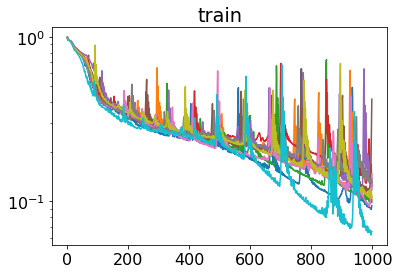

In [47]:
plot_history(history1s)

In [48]:
yhat1 = model1.predict(x)

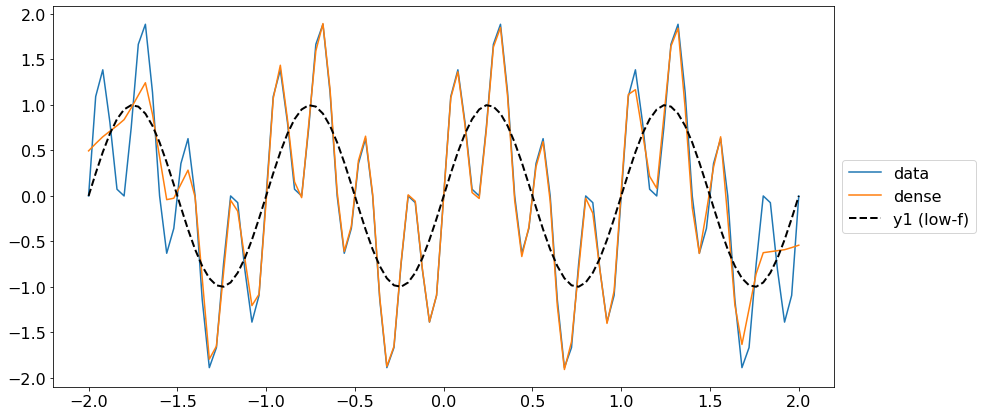

In [49]:
plt.figure(figsize=(14, 7))
plt.plot(x, y, label='data')
plt.plot(x, yhat1, label='dense')
plt.plot(x, y1, label='y1 (low-f)', lw=2, c='k', ls='--')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# M-scale network

In [50]:
%%time
ntries = 10
history2s = []
model2s = []

print("working")
for i in range(ntries):
    print(f"{i}", end=",")
    history, model = build_and_fit_model(x, y, activation='s2relu', epochs=1000, nscales=10, units=300, scale_name='linear', use_mscale=True)

    history2s.append(history)
    model2s.append(model)
print("done")

working
0,1,2,3,4,5,6,7,8,9,done
CPU times: user 2min, sys: 28 s, total: 2min 28s
Wall time: 43.8 s


In [51]:
history2, model2 = lowest_loss(history2s, model2s)

idx: 8 had the lowest loss


In [52]:
model2.layers[0].K.numpy()

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  4.,
        4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
        4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
        4.,  4.,  4.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  6.,  6.,  6.,  6.,  6.,  6.,
        6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
        6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  7

In [53]:
np.unique(model2.layers[0].K.numpy())

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.], dtype=float32)

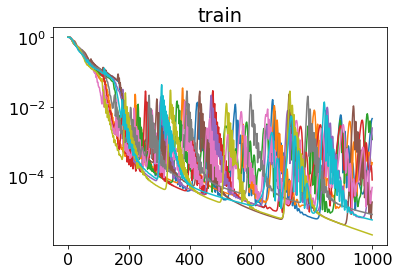

In [54]:
plot_history(history2s)

In [55]:
yhat2 = model2.predict(x)

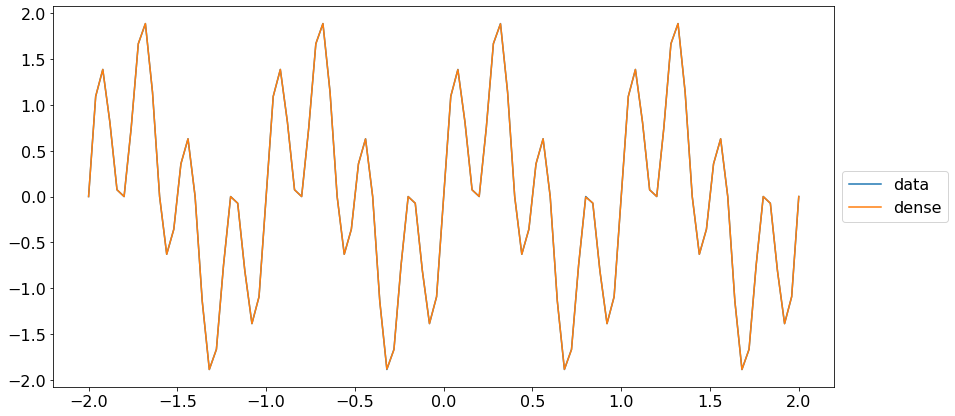

In [56]:
plt.figure(figsize=(14, 7))
plt.plot(x, y, label='data')
plt.plot(x, yhat2, label='dense')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [57]:
_, yhat1f = compute_fft(x[:,0], yhat1[:,0])

In [58]:
_, yhat2f = compute_fft(x[:,0], yhat2[:,0])

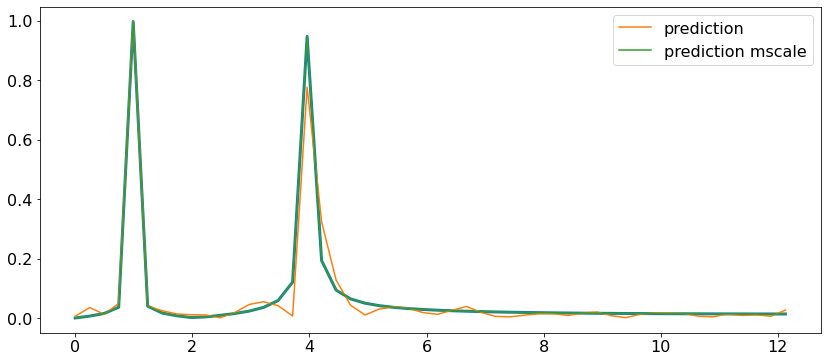

In [65]:
plt.figure(figsize=(14, 6))
plt.plot(xf, np.abs(yf), lw=3)
# plt.plot(xf, np.abs(y1f), ls='--')
# plt.plot(xf, np.abs(y2f), ls='--')

plt.plot(xf, np.abs(yhat1f), label='prediction')

plt.plot(xf, np.abs(yhat2f), label='prediction mscale')

# plt.axvline(1, c='k', ls='--')
# plt.axvline(4, c='k', ls='--')

plt.legend()

We see that even after 1000 epochs (10 times longer training than before) that the standard dense network cannot hope to compete with the M-scale network.

The time and frequency domain plots look incredible. The M-scale network has an extremely high level of accuracy.

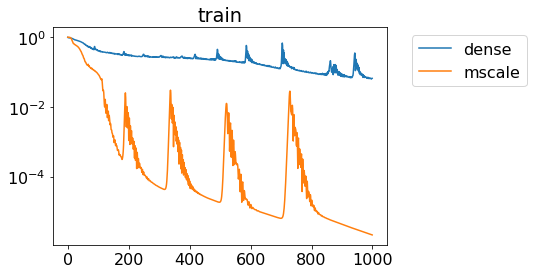

In [61]:
plot_history([history1, history2], labels=['dense', 'mscale'])

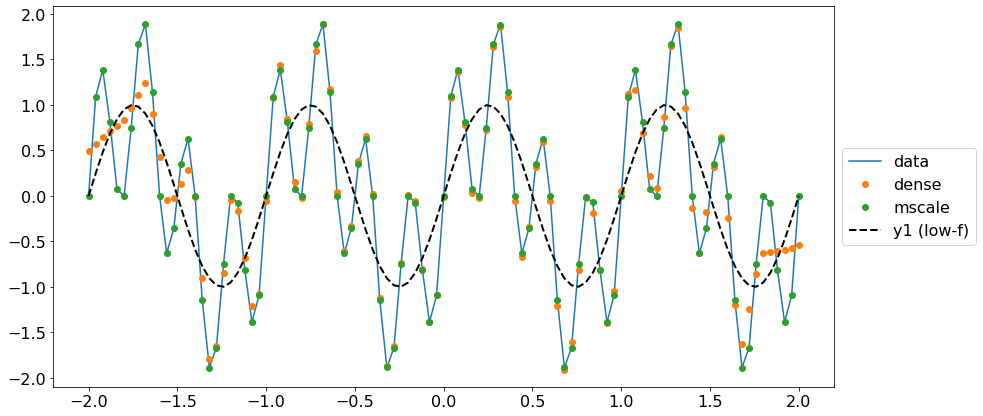

In [62]:
plt.figure(figsize=(14, 7))
plt.plot(x, y, '-', label='data')
plt.plot(x, yhat1, 'o', label='dense')
plt.plot(x, yhat2, 'o', label='mscale')
plt.plot(x, y1, label='y1 (low-f)', lw=2, c='k', ls='--')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [63]:
yres1 = tf.keras.losses.mse(y, yhat1)
yres2 = tf.keras.losses.mse(y, yhat2)

Text(0.5, 1.0, 'MSE residuals')

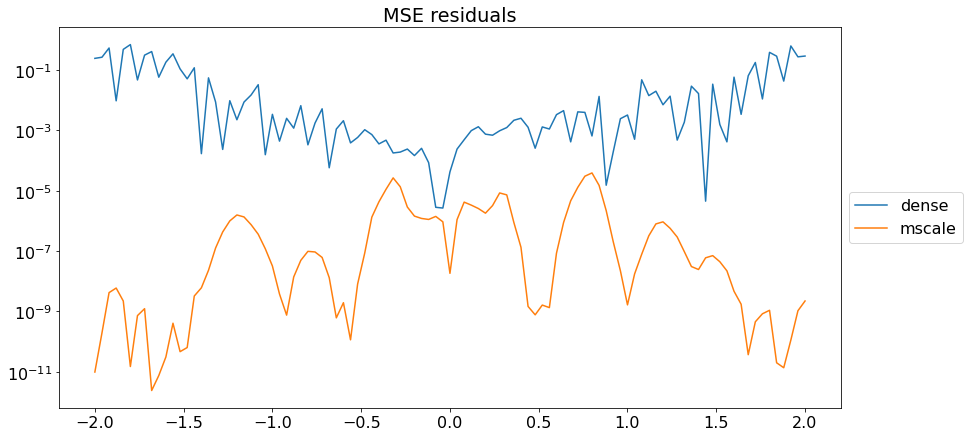

In [64]:
plt.figure(figsize=(14, 7))
plt.plot(x, yres1, '-', label='dense')
plt.plot(x, yres2, '-', label='mscale')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.yscale('log')
plt.title("MSE residuals")

As a final check lets check against some validation data.

We will just generate the training data at more points to achieve this

In [66]:
x, y, y1, y2 = gen_data(npoints=1001)

In [67]:
yhat1 = model1.predict(x)
yhat2 = model2.predict(x)

In [70]:
xf, yf = compute_fft(x[:,0], y[:,0])
_, yhat1f = compute_fft(x[:,0], yhat1[:,0])
_, yhat2f = compute_fft(x[:,0], yhat2[:,0])

In [78]:
yres1 = tf.keras.losses.mse(y, yhat1)
yres2 = tf.keras.losses.mse(y, yhat2)

(0.0, 10.0)

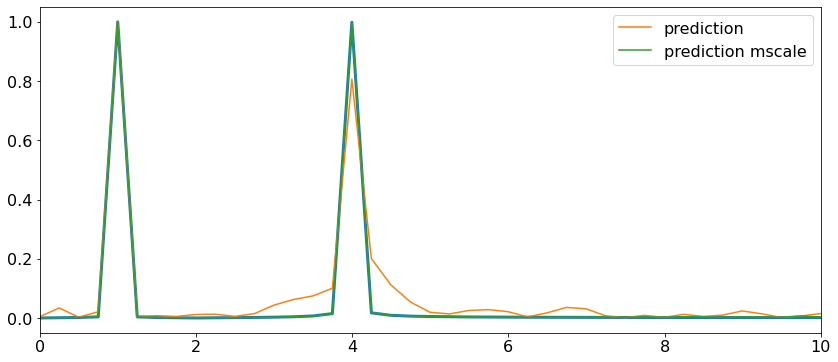

In [73]:
plt.figure(figsize=(14, 6))
plt.plot(xf, np.abs(yf), lw=3)
# plt.plot(xf, np.abs(y1f), ls='--')
# plt.plot(xf, np.abs(y2f), ls='--')

plt.plot(xf, np.abs(yhat1f), label='prediction')

plt.plot(xf, np.abs(yhat2f), label='prediction mscale')

# plt.axvline(1, c='k', ls='--')
# plt.axvline(4, c='k', ls='--')

plt.legend()

plt.xlim(0, 10)

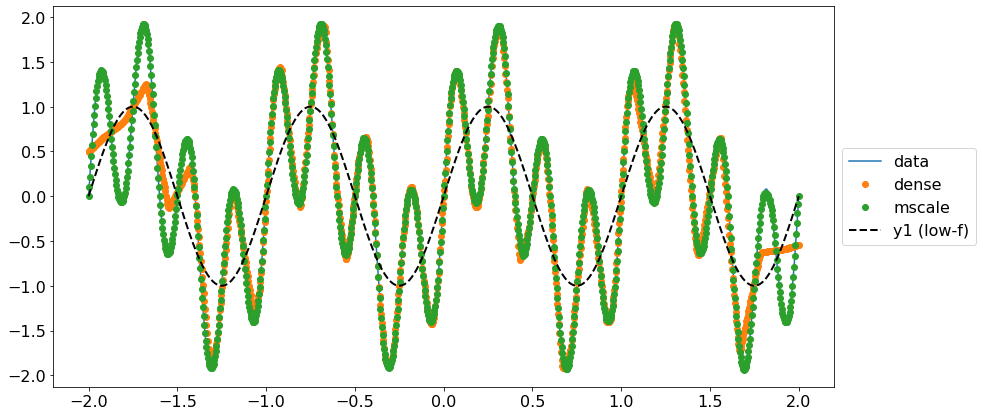

In [77]:
plt.figure(figsize=(14, 7))
plt.plot(x, y, '-', label='data')
plt.plot(x, yhat1, 'o', label='dense')
plt.plot(x, yhat2, 'o', label='mscale')
plt.plot(x, y1, label='y1 (low-f)', lw=2, c='k', ls='--')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Text(0.5, 1.0, 'MSE residuals')

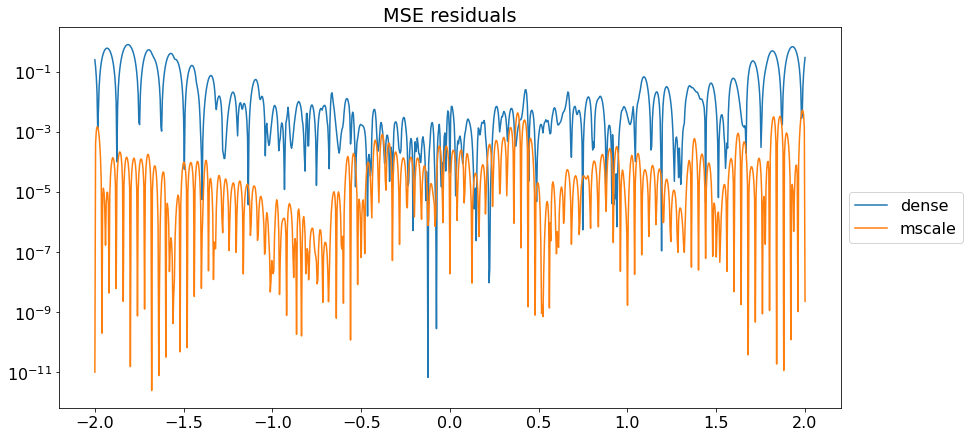

In [79]:
plt.figure(figsize=(14, 7))
plt.plot(x, yres1, '-', label='dense')
plt.plot(x, yres2, '-', label='mscale')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.yscale('log')
plt.title("MSE residuals")

We are looking for any extra features, high frequency oscillations in the prediction. This can happen when the network overfits and the performance on unseen data can be poor.

In that case the model would not generalise well and would not be very useful.

This is not the case here though so things look great!